In [1]:
%matplotlib inline
import pandas as pd

In [55]:
compras_df=pd.read_csv('data/clean_compras_2024.csv')

In [57]:
# Creamos una copia del dataframe
data=compras_df.copy()

### Llenar los valores faltantes del dataframe

In [60]:
# Completamos los datos faltantes y categorizamos las variables
for i, column in enumerate(list([str(d) for d in data.dtypes])):
    if column == "object":
        data[data.columns[i]]=data[data.columns[i]].fillna(data[data.columns[i]].mode())
        data[data.columns[i]]=data[data.columns[i]].astype("category").cat.codes
    else:
        data[data.columns[i]]=data[data.columns[i]].fillna(data[data.columns[i]].median())

In [62]:
data.head(4)

,C B,BENEFICIARIO,RFC,FACTURAS,CONTRATO,CONCEPTO,TIPO,FDO - #OP,FECHA,IMPORTE,SHEET
0,126753,876,904,6710,44,537,1,351000898.0,0,2429742.44,1
1,126753,876,904,6488,44,1654,1,351000899.0,0,906239.26,1
2,206273,1657,1560,11985,44,7672,1,1029199.0,0,4889.00,1
3,206273,1657,1560,1077,44,7680,1,353000038.0,0,1674610.00,1


### **MODELO SUPERVISADO**

#### **RANDOM FOREST**

In [66]:
# Importamos las bibliotecas
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [68]:
# Definimos las variables
y=data.pop('IMPORTE')
y

0        2429742.44
1         906239.26
2           4889.00
3        1674610.00
4        2356642.00
            ...    
13737       1871.49
13738       2481.47
13739       2481.47
13740        825.68
13741       2064.20
Name: IMPORTE, Length: 13742, dtype: float64

In [74]:
X=data.copy()
X

,C B,BENEFICIARIO,RFC,FACTURAS,CONTRATO,CONCEPTO,TIPO,FDO - #OP,FECHA,SHEET
0,126753,876,904,6710,44,537,1,351000898.0,0,1
1,126753,876,904,6488,44,1654,1,351000899.0,0,1
2,206273,1657,1560,11985,44,7672,1,1029199.0,0,1
3,206273,1657,1560,1077,44,7680,1,353000038.0,0,1
4,206273,1657,1560,11984,44,3288,1,354000119.0,0,1
...,...,...,...,...,...,...,...,...,...,...
13737,203016,807,821,2200,44,5704,0,373000509.0,147,3
13738,203016,645,662,5205,44,5720,0,373000510.0,147,3
13739,203016,1069,1056,5124,44,5699,0,373000511.0,147,3
13740,203016,29,444,169,46,5729,0,373000512.0,147,3


#### **Dividimos los datos en 2 grupos**

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [78]:
# Creamos un clasificador
clf = RandomForestRegressor(n_estimators=1000, max_depth = 4)

In [80]:
# Entrenamos el modelo
clf.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, n_estimators=1000)

In [82]:
# Evaluamos el rendimiento del modelo

In [86]:
# Importamos la libreria
from sklearn.metrics import r2_score

In [90]:
# Realizamos las predicciones
r2_score(y_test, clf.predict(X_test))

0.22704951390244976

In [96]:
# Como resultado obtuvimos que el modelo explica:
# el 22.7% de la variabilidad de la variable dependiente.
# lo cual no representa un ajuste muy bueno. 

### **MODELO NO SUPERVISADO O DE CLUSTERING**

In [100]:
# Importamos las librerias
import warnings
warnings.filterwarnings("ignore",category=UserWarning, module="sklearn")
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [102]:
compras_df_c = compras_df.copy()

In [106]:
# Agrupamos los datos combinados con los valores unicos de la columna contrato y factura por beneficiario
compras_df_c_grupo = compras_df_c.groupby('BENEFICIARIO').agg({'CONTRATO': lambda x: x.nunique(), 'IMPORTE': 'sum',
                                                              'FACTURAS': lambda x: x.nunique()})

In [112]:
compras_df_cluster = compras_df_c_grupo.reset_index()
compras_df_cluster
# Visualizams el beneficiario con su numero de contrato,
# la suma del importe y el numero de facturas

,BENEFICIARIO,CONTRATO,IMPORTE,FACTURAS
0,A.R. CANALES S.C.,1,20398.64,1
1,ABAD MORENO MILCA SARAI,1,8925.91,1
2,ABASTECEDORA DE EMPACADORAS Y RASTROS SA DE CV,1,20783.52,1
3,ABUNDIS ALBERTO,1,316296.22,8
4,ABURTO HERRERA ANDREA MARIA DE LOS ANGELES,1,30518.37,2
...,...,...,...,...
1813,ZAVALA ROMERO OMAR,1,10458.85,1
1814,ZEPEDA GONZALEZ DANIEL MARINO,1,17690.88,2
1815,ZUÑIGA FRIAS MARIBEL,1,21536.42,1
1816,ZUÑIGA GUERRERO MARTHA,1,68319.74,1


In [114]:
# Eliminamos la columna beneficiario
compras_df_c_grupo_f = compras_df_c_grupo.reset_index().drop(['BENEFICIARIO'], axis=1)

In [118]:
# Normalizamos los datos
normalizado_compras_df = (compras_df_c_grupo_f - compras_df_c_grupo_f.min())/(compras_df_c_grupo_f.max()-compras_df_c_grupo_f.min())
normalizado_compras_df

,CONTRATO,IMPORTE,FACTURAS
0,0.0,0.000016,0.000000
1,0.0,0.000007,0.000000
2,0.0,0.000016,0.000000
3,0.0,0.000250,0.003838
4,0.0,0.000024,0.000548
...,...,...,...
1813,0.0,0.000008,0.000000
1814,0.0,0.000014,0.000548
1815,0.0,0.000017,0.000000
1816,0.0,0.000054,0.000000


#### **Implementamos el metodo "Codo de Jambu"**

In [123]:
# Inicializamos una lista
wcss=[]

In [125]:
# Ejecutamos Kmeans por los diferentes numeros de cluster
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, max_iter=300)
    kmeans.fit(normalizado_compras_df)
    wcss.append(kmeans.inertia_)

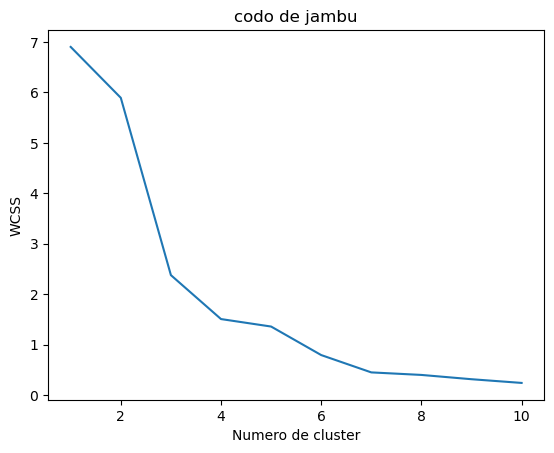

In [129]:
# Graficamos el codo de jambu
plt.plot(range(1,11), wcss)
plt.title('codo de jambu')
plt.xlabel('Numero de cluster')
plt.ylabel('WCSS') #Indica la cantidad de similitud de los individuos
plt.show()

In [131]:
# Determinamos el numero optimo de cluster, en este caso esta en el rango de 3 a 4

In [135]:
# Creamos una nueva instancia con 3 cluster
clustering = KMeans(n_clusters = 3, max_iter= 300)

In [137]:
# Entrenamos el modelo
clustering.fit(normalizado_compras_df)

KMeans(n_clusters=3)

In [141]:
# Asignamos las etiquetas a cada observacion
compras_df_cluster['KMeans_Cluster'] = clustering.labels_

In [143]:
compras_df_cluster['KMeans_Cluster'].value_counts()

KMeans_Cluster
0    1810
1       7
2       1
Name: count, dtype: int64

#### **Implementamos PCA**

In [147]:
# Importamos la libreria
from sklearn.decomposition import PCA

In [149]:
# Creamos una instancia de PCA y definimos 2 componentes principales o 2 dimensiones
pca=PCA(n_components=2)

In [151]:
# Ajustamos y Transformamos los datos a las 2 dimensiones
pca_compras = pca.fit_transform(normalizado_compras_df)

In [153]:
# Convertimos a un dataframe de pandas
pca_compras_df = pd.DataFrame(data = pca_compras, columns = ['componente_1', 'componente_2'])

In [155]:
# Concatenamos con los nombres de los beneficiarios
pca_nombres_beneficiarios = pd.concat([pca_compras_df, compras_df_cluster['KMeans_Cluster']], axis=1)
pca_nombres_beneficiarios

,componente_1,componente_2,KMeans_Cluster
0,-0.007680,-0.002859,0
1,-0.007681,-0.002868,0
2,-0.007680,-0.002859,0
3,-0.006025,-0.001927,0
4,-0.007445,-0.002750,0
...,...,...,...
1813,-0.007681,-0.002867,0
1814,-0.007445,-0.002760,0
1815,-0.007680,-0.002858,0
1816,-0.007679,-0.002822,0


In [165]:
# Graficamos los Clusters
plt.figure(figsize=(10,8))

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

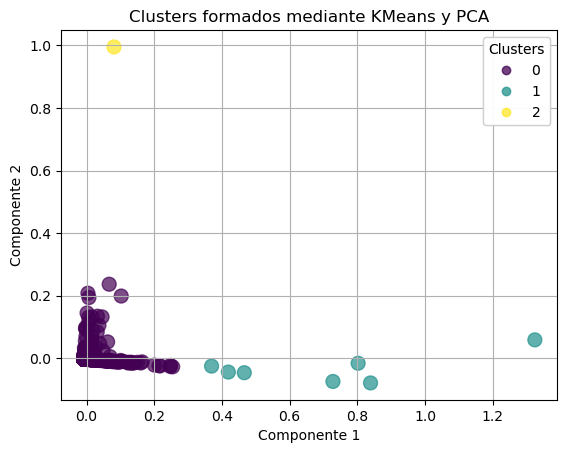

In [173]:
scatter = plt.scatter(pca_nombres_beneficiarios['componente_1'],
                     pca_nombres_beneficiarios['componente_2'],
                     c=pca_nombres_beneficiarios['KMeans_Cluster'],
                     cmap='viridis',
                     s=100,
                     alpha=0.7)
plt.title('Clusters formados mediante KMeans y PCA')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
legend1 = plt.legend(*scatter.legend_elements(), title='Clusters')
plt.gca().add_artist(legend1)
plt.grid()
plt.show()